# Otimização de Campanha de Sondas - Versão Final Corrigida

**Inclui:**
- Respeito à parada programada (adição à duração final)
- Comentários em blocos de texto para explicar passo a passo
- Mantém toda a estrutura do notebook final marcado
- Pronto para ser a nova base de referência

## Instalação de bibliotecas necessárias

In [1]:
!pip install pandas numpy pulp matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 71.9 MB/s eta 0:00:00


## Importação de pacotes e carregamento de dados

In [2]:
import pandas as pd
import numpy as np
from pulp import LpProblem, LpVariable, LpMinimize, lpSum, LpBinary, LpStatus
import matplotlib.pyplot as plt
from datetime import timedelta

# Carregar bases
df_pocos = pd.read_csv('pocos.csv')
df_sondas = pd.read_csv('sondas.csv')
df_pocos['Data_Inicio'] = pd.to_datetime(df_pocos['Ano_Inicio'].astype(str) + '-' + df_pocos['Mes_Inicio'].astype(str) + '-01')

print('Poços:')
display(df_pocos.head())

print('Sondas:')
display(df_sondas.head())


Poços:


,Poço,Profundidade (m),Pressão Estimada (PSI),Ano_Inicio,Mes_Inicio,Janela de Perfuração (dias),Data_Inicio
0,P-001,2459,3860,2026,7,84,2026-07-01
1,P-002,2095,6772,2026,11,90,2026-11-01
2,P-003,1121,3466,2026,7,92,2026-07-01
3,P-004,2482,9231,2026,11,105,2026-11-01
4,P-005,2687,3130,2026,8,91,2026-08-01


Sondas:


,Sonda,Tipo,Profundidade Máxima (m),BOP (PSI Máx.),Capacidade Logística,Custo Operação (USD/dia),Tempo de Setup (dias),Dias de Operação Contínua,Dias de Parada Programada
0,Sonda-1,Drillship,1600,10500,Média,455000,2,60,3
1,Sonda-2,Semi,1700,11000,Média,460000,2,60,3
2,Sonda-3,Drillship,1800,11500,Alta,465000,2,60,3
3,Sonda-4,Semi,1900,12000,Média,470000,2,60,3
4,Sonda-5,Drillship,2000,12500,Média,475000,2,60,3


## Geração da matriz de compatibilidade
Verifica se a sonda suporta as exigências técnicas do poço

In [3]:
matriz_compatibilidade = []
for _, poço in df_pocos.iterrows():
    for _, sonda in df_sondas.iterrows():
        compativel = int(
            (sonda['Profundidade Máxima (m)'] >= poço['Profundidade (m)']) and
            (sonda['BOP (PSI Máx.)'] >= poço['Pressão Estimada (PSI)'])
        )
        matriz_compatibilidade.append({'Poço': poço['Poço'], 'Sonda': sonda['Sonda'], 'Compatível': compativel})
df_compatibilidade = pd.DataFrame(matriz_compatibilidade)

print('Matriz de compatibilidade:')
display(df_compatibilidade.head())

Matriz de compatibilidade:


,Poço,Sonda,Compatível
0,P-001,Sonda-1,0
1,P-001,Sonda-2,0
2,P-001,Sonda-3,0
3,P-001,Sonda-4,0
4,P-001,Sonda-5,0


## Modelagem de otimização
Minimiza o custo total e garante compatibilidade e alocação única

In [4]:
modelo = LpProblem('Otimização_Campanha_Sondas', LpMinimize)
variaveis = {}
for _, poço in df_pocos.iterrows():
    for _, sonda in df_sondas.iterrows():
        chave = (poço['Poço'], sonda['Sonda'])
        variaveis[chave] = LpVariable(f"x_{poço['Poço']}_{sonda['Sonda']}", cat=LpBinary)

# Função objetivo
modelo += lpSum(
    variaveis[(poço['Poço'], sonda['Sonda'])] * sonda['Custo Operação (USD/dia)']
    for _, poço in df_pocos.iterrows()
    for _, sonda in df_sondas.iterrows()
), 'Custo_Total'

# Restrições de compatibilidade e alocação única
for _, linha in df_compatibilidade.iterrows():
    if linha['Compatível'] == 0:
        modelo += variaveis[(linha['Poço'], linha['Sonda'])] == 0

for _, poço in df_pocos.iterrows():
    modelo += lpSum(
        variaveis[(poço['Poço'], sonda['Sonda'])] for _, sonda in df_sondas.iterrows()
    ) == 1

## Respeitando as datas e evitando sobreposição

In [5]:
for _, sonda in df_sondas.iterrows():
    for dia in pd.date_range('2026-01-01', '2030-12-31'):
        modelo += lpSum(
            variaveis[(poço['Poço'], sonda['Sonda'])]
            for _, poço in df_pocos.iterrows()
            if (poço['Data_Inicio'] <= dia <= poço['Data_Inicio'] + timedelta(days=int(poço['Janela de Perfuração (dias)'])))
        ) <= 1

## Resolução e verificação de status

In [6]:
modelo.solve()
print('Status:', LpStatus[modelo.status])

Status: Optimal


## Ajuste de datas finais com parada programada incluída

In [7]:
# Construir dataframe de alocações e ajustar datas finais
alocacoes = [(poço, sonda) for (poço, sonda), var in variaveis.items() if var.varValue == 1]
df_alocacoes = pd.DataFrame(alocacoes, columns=['Poço', 'Sonda'])
df_alocacoes = df_alocacoes.merge(df_pocos[['Poço', 'Janela de Perfuração (dias)', 'Data_Inicio']], on='Poço', how='left')
df_alocacoes = df_alocacoes.merge(df_sondas[['Sonda', 'Tempo de Setup (dias)', 'Dias de Operação Contínua', 'Dias de Parada Programada']], on='Sonda', how='left')

# Adiciona parada programada ao tempo total
df_alocacoes['Duração_Total'] = df_alocacoes['Janela de Perfuração (dias)'] + df_alocacoes['Dias de Parada Programada']
df_alocacoes['Início'] = df_alocacoes['Data_Inicio'] + pd.to_timedelta(df_alocacoes['Tempo de Setup (dias)'], unit='D')
df_alocacoes['Fim'] = df_alocacoes['Início'] + pd.to_timedelta(df_alocacoes['Duração_Total'] - 1, unit='D')

## Visualização no Gantt e tabela

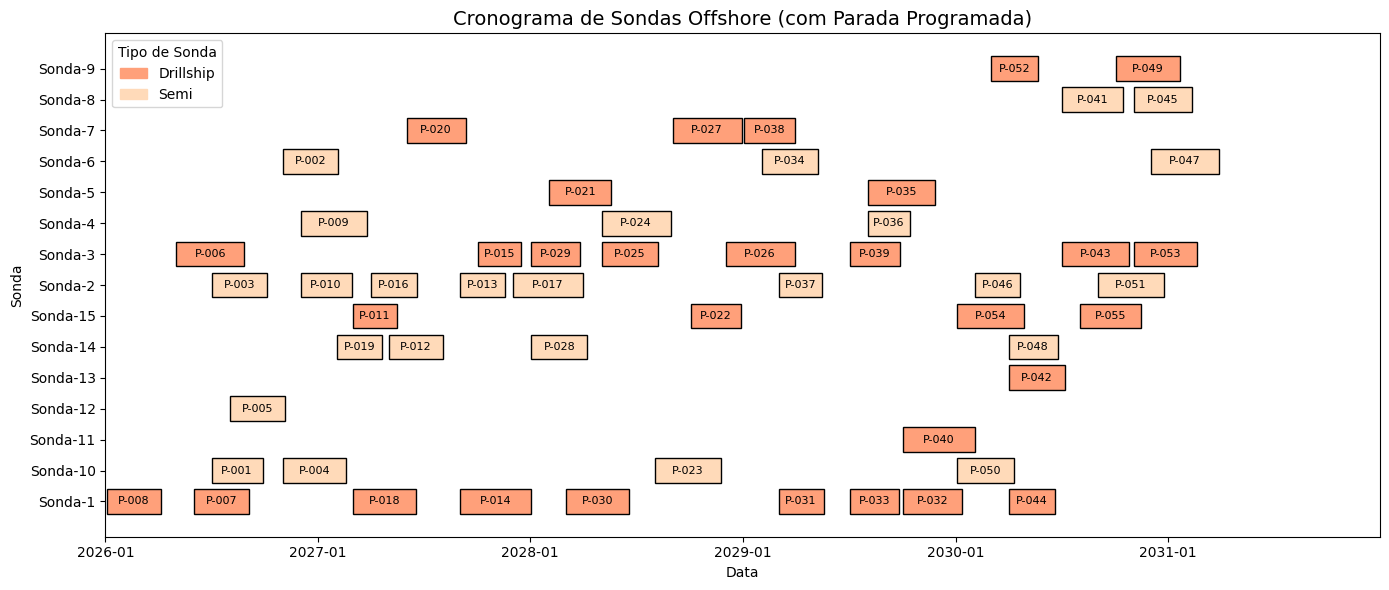

Tabela final ordenada:


,Sonda,Poço,Início,Fim,Duração_Total,Custo_Total_Poço
7,Sonda-1,P-008,2026-01-03,2026-04-06,94,42770000
6,Sonda-1,P-007,2026-06-03,2026-09-03,93,42315000
17,Sonda-1,P-018,2027-03-03,2027-06-18,108,49140000
13,Sonda-1,P-014,2027-09-03,2028-01-02,122,55510000
29,Sonda-1,P-030,2028-03-03,2028-06-17,107,48685000
30,Sonda-1,P-031,2029-03-03,2029-05-18,77,35035000
32,Sonda-1,P-033,2029-07-03,2029-09-24,84,38220000
31,Sonda-1,P-032,2029-10-03,2030-01-10,100,45500000
43,Sonda-1,P-044,2030-04-03,2030-06-20,79,35945000
0,Sonda-10,P-001,2026-07-03,2026-09-27,87,43500000


In [8]:
# Ordenar alocações por sonda e data de início
df_alocacoes.sort_values(['Sonda', 'Início'], inplace=True)

# Calcular o custo total de cada poço
df_alocacoes['Custo_Total_Poço'] = df_alocacoes.apply(
    lambda row: df_sondas.loc[df_sondas['Sonda'] == row['Sonda'], 'Custo Operação (USD/dia)'].values[0] * row['Duração_Total'],
    axis=1
)

# Preparar as cores para os tipos de sonda
cores_sondas = {
    'Drillship': '#FFA07A',  # Laranja claro (salmon claro)
    'Semi': '#FFDAB9'        # Salmão claro (peachpuff)
}

# Plotar o gráfico Gantt
fig, ax = plt.subplots(figsize=(14, 6))

for i, row in df_alocacoes.iterrows():
    tipo_sonda = df_sondas.loc[df_sondas['Sonda'] == row['Sonda'], 'Tipo'].values[0]
    cor = cores_sondas.get(tipo_sonda, 'grey')
    ax.barh(row['Sonda'], row['Duração_Total'], left=row['Início'], color=cor, edgecolor='black')
    ax.text(row['Início'] + timedelta(days=int(row['Duração_Total']//2)),
            row['Sonda'], row['Poço'], ha='center', va='center', color='black', fontsize=8)

# Ajustar o eixo x para mostrar ano e mês
ax.set_xlim(pd.to_datetime('2026-01-01'), pd.to_datetime('2031-12-31'))
ax.xaxis_date()
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

# Adicionar legenda manualmente
import matplotlib.patches as mpatches
legenda = [mpatches.Patch(color=cor, label=tipo) for tipo, cor in cores_sondas.items()]
ax.legend(handles=legenda, title='Tipo de Sonda', loc='upper left')

ax.set_xlabel('Data')
ax.set_ylabel('Sonda')
ax.set_title('Cronograma de Sondas Offshore (com Parada Programada)', fontsize=14)
plt.tight_layout()
plt.show()

# Exibir tabela final ordenada com custo
print('Tabela final ordenada:')
display(df_alocacoes[['Sonda', 'Poço', 'Início', 'Fim', 'Duração_Total', 'Custo_Total_Poço']])


## Cálculo do custo total da campanha

In [9]:
if LpStatus[modelo.status] == 'Optimal':
    custo_total = sum(
        df_sondas.loc[df_sondas['Sonda'] == row['Sonda'], 'Custo Operação (USD/dia)'].values[0] * row['Duração_Total']
        for _, row in df_alocacoes.iterrows()
    )
    print(f"Custo total da campanha (USD): {custo_total:,.2f}")
else:
    print("Não foi possível encontrar uma solução ótima.")

Custo total da campanha (USD): 2,577,450,000.00


In [10]:
# 📄 Gerar um PDF com capa, Gantt, tabela e custo total

from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('relatorio_final.pdf') as pdf:
    # 🎯 0️⃣ Capa do relatório
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')
    ax.text(0.5, 0.5, "Relatório de otimização da campanha de poços offshore",
            ha='center', va='center', fontsize=20, fontweight='bold', color='navy')
    pdf.savefig(fig)
    plt.close()

    # 1️⃣ Plotar Gantt no PDF (conversão explícita de datas!)
    fig, ax = plt.subplots(figsize=(14, 6))
    for i, row in df_alocacoes.iterrows():
        tipo_sonda = df_sondas.loc[df_sondas['Sonda'] == row['Sonda'], 'Tipo'].values[0]
        cor = cores_sondas.get(tipo_sonda, 'grey')

        # Conversão de Início para datetime (se estiver como string)
        inicio_dt = pd.to_datetime(row['Início'])

        ax.barh(row['Sonda'], row['Duração_Total'], left=inicio_dt, color=cor, edgecolor='black')
        ax.text(inicio_dt + timedelta(days=int(row['Duração_Total']//2)),
                row['Sonda'], row['Poço'], ha='center', va='center', color='black', fontsize=8)

    ax.set_xlim(pd.to_datetime('2026-01-01'), pd.to_datetime('2031-12-31'))
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

    import matplotlib.patches as mpatches
    legenda = [mpatches.Patch(color=cor, label=tipo) for tipo, cor in cores_sondas.items()]
    ax.legend(handles=legenda, title='Tipo de Sonda', loc='upper left')

    ax.set_xlabel('Data')
    ax.set_ylabel('Sonda')
    ax.set_title('Cronograma de Sondas Offshore (com Parada Programada)', fontsize=14)
    plt.tight_layout()
    pdf.savefig(fig)
    plt.close()

    # 2️⃣ Ajustar as datas como string **apenas para a tabela final**
    df_alocacoes_copy = df_alocacoes.copy()
    df_alocacoes_copy['Início'] = pd.to_datetime(df_alocacoes_copy['Início']).dt.strftime('%Y-%m-%d')
    df_alocacoes_copy['Fim'] = pd.to_datetime(df_alocacoes_copy['Fim']).dt.strftime('%Y-%m-%d')

    # Adicionar a tabela final ordenada no PDF
    from pandas.plotting import table
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis('off')
    tbl = table(ax, df_alocacoes_copy[['Sonda', 'Poço', 'Início', 'Fim', 'Duração_Total', 'Custo_Total_Poço']],
                 loc='center', colWidths=[0.13]*6)
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(4)   # Fonte menor
    tbl.scale(0.5, 0.5)   # Reduzir o tamanho da tabela
    ax.set_title('Tabela Final Ordenada', fontsize=12, fontweight='bold')
    pdf.savefig(fig)
    plt.close()

    # 3️⃣ Adicionar o custo total final ao PDF
    if LpStatus[modelo.status] == 'Optimal':
        fig, ax = plt.subplots(figsize=(8, 2))
        ax.axis('off')
        custo_total = sum(
            df_sondas.loc[df_sondas['Sonda'] == row['Sonda'], 'Custo Operação (USD/dia)'].values[0] * row['Duração_Total']
            for _, row in df_alocacoes.iterrows()
        )
        ax.text(0.5, 0.5, f"Custo total da campanha (USD): {custo_total:,.2f}",
                ha='center', va='center', fontsize=14, weight='bold', color='darkgreen')
        pdf.savefig(fig)
        plt.close()
    else:
        fig, ax = plt.subplots(figsize=(8, 2))
        ax.axis('off')
        ax.text(0.5, 0.5, "Não foi possível encontrar uma solução ótima.",
                ha='center', va='center', fontsize=14, color='red')
        pdf.savefig(fig)
        plt.close()

print("PDF gerado com sucesso: relatorio_final.pdf")


PDF gerado com sucesso: relatorio_final.pdf
